In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from ctgan import CTGAN

In [2]:
df = pd.read_csv("data/german/german_credit_data.csv",index_col=0)
df = df.fillna("no_info")

In [3]:
discrete_columns = [
    'Sex',
    'Housing',
    'Saving accounts',
    'Checking account',
    'Purpose',
    'Risk',
]

ctgan = CTGAN(epochs=10)
ctgan.fit(df, discrete_columns)

# Create synthetic data
ctgan_data = ctgan.sample(1000)

/home/daniel/anaconda3/envs/d3vis/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
import pandas as pd
import numpy as np
from snsynth.pytorch.nn import PATECTGAN
from snsynth.pytorch import PytorchDPSynthesizer


synth = PytorchDPSynthesizer(1.0, PATECTGAN(regularization='dragan'), None)
synth.fit(df, categorical_columns=df.columns.values.tolist())

synth_data = synth.sample(1000) # synthesize 10 rows

using loss cross_entropy and regularization dragan
eps: 0.103616 	 G: 3.082711 	 D: 0.697185
eps: 0.460253 	 G: 2.949699 	 D: 0.694967
eps: 0.653801 	 G: 2.979990 	 D: 0.695662
eps: 0.803524 	 G: 2.873371 	 D: 0.691597
eps: 0.930506 	 G: 2.924369 	 D: 0.695309


In [5]:
def transformar_dados(df):
    interval = (18, 25, 35, 60, 120)

    cats = ['Student', 'Young', 'Adult', 'Senior']
    df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)
    df = df.merge(pd.get_dummies(df.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
    df = df.merge(pd.get_dummies(df.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
    df = df.merge(pd.get_dummies(df.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
    df = df.merge(pd.get_dummies(df["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
    df = df.merge(pd.get_dummies(df.Risk, prefix='Risk'), left_index=True, right_index=True)
    df = df.merge(pd.get_dummies(df["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
    df = df.merge(pd.get_dummies(df["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)
    
    del df["Saving accounts"]
    del df["Checking account"]
    del df["Purpose"]
    del df["Sex"]
    del df["Housing"]
    del df["Age_cat"]
    del df["Risk"]
    del df['Risk_good']

    df['Credit amount'] = np.log(df['Credit amount'])
    df = df.dropna()
    return df

In [6]:
models_df = pd.DataFrame(index=['LR', 'LDA', 'KNN', 'CART', 'NB', 'RF', 'SVM', 'XGB'])

def treinar(df, df_name):
    X = df.drop('Risk_bad', axis=1).values
    y = df["Risk_bad"].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

    seed = 7

    # prepare models
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('SVM', SVC(gamma='auto')))
    models.append(('XGB', XGBClassifier()))
    
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'recall'
    
    for name, model in models:
            kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
            cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
            results.append(cv_results)
            names.append(name)
            msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            print(msg)

    res_df = pd.DataFrame({df_name: map(lambda x: x.mean(), results)}, index=names)
    global models_df
    models_df = pd.concat([models_df, res_df], axis=1)
            
    # boxplot algorithm comparison
    fig = plt.figure(figsize=(11,6))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

/home/daniel/anaconda3/envs/d3vis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/daniel/anaconda3/envs/d3vis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

LR: 0.399643 (0.083334)
LDA: 0.424515 (0.085843)
KNN: 0.282062 (0.079976)
CART: 0.464304 (0.040059)
NB: 0.610248 (0.074303)
RF: 0.392568 (0.077788)
SVM: 0.143989 (0.055608)
XGB: 0.473971 (0.058236)


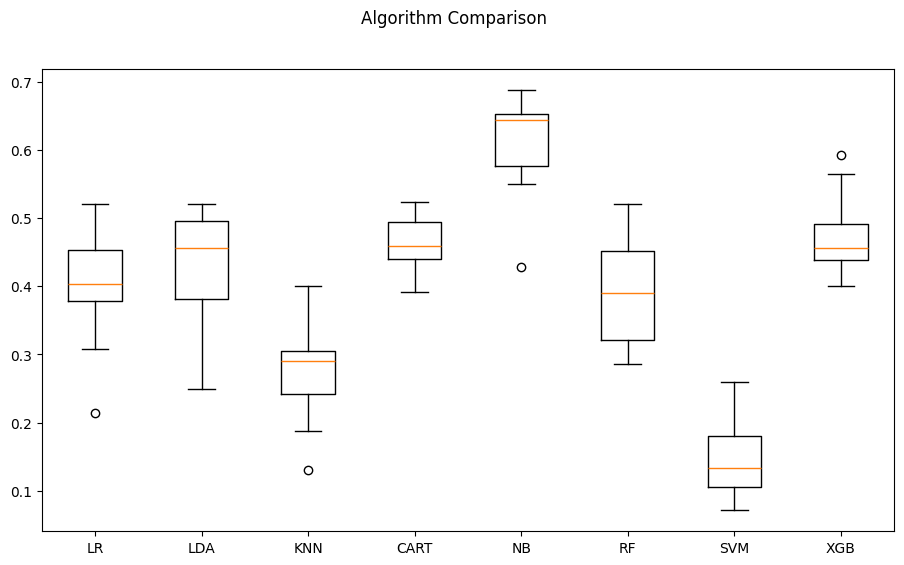

In [7]:
df = transformar_dados(df)
treinar(df, "original")

/home/daniel/anaconda3/envs/d3vis/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/daniel/anaconda3/envs/d3vis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/daniel/anaconda3/envs/d3vis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as 

LR: 0.624209 (0.062317)
LDA: 0.599761 (0.060876)
KNN: 0.416921 (0.062827)
CART: 0.622742 (0.071263)
NB: 0.367157 (0.090883)
RF: 0.623073 (0.041200)
SVM: 0.463745 (0.057663)
XGB: 0.651900 (0.038429)


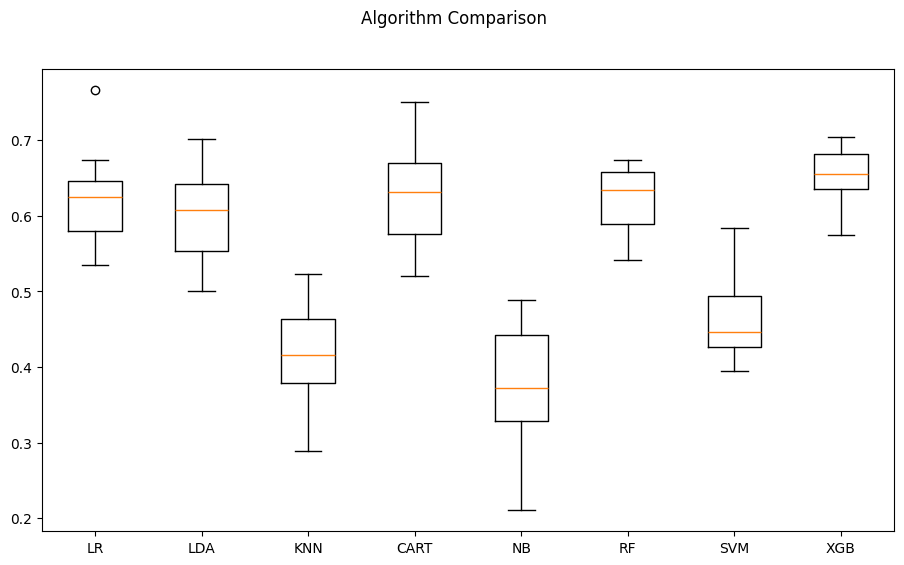

In [8]:
ctgan_data = transformar_dados(ctgan_data)
ctgan_data = ctgan_data.drop(ctgan_data[ctgan_data['Risk_bad'] == False].index)
df0 = pd.concat([df, ctgan_data])
treinar(df0, "ctgan")

In [9]:
synth_data

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,21,male,2,own,little,little,14896,21,radio/TV,good
1,36,female,0,own,no_info,no_info,685,12,furniture/equipment,good
2,59,female,0,rent,rich,rich,4771,10,car,good
3,74,male,0,own,moderate,no_info,3976,20,car,good
4,38,female,3,rent,quite rich,moderate,4280,21,car,good
...,...,...,...,...,...,...,...,...,...,...
995,63,male,3,free,rich,no_info,385,6,radio/TV,bad
996,31,female,2,rent,quite rich,rich,1188,48,car,bad
997,20,female,1,own,little,no_info,3345,14,car,bad
998,30,male,0,rent,moderate,rich,7374,54,domestic appliances,good


/home/daniel/anaconda3/envs/d3vis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/daniel/anaconda3/envs/d3vis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

LR: 0.730471 (0.066799)
LDA: 0.720072 (0.070707)
KNN: 0.558996 (0.049534)
CART: 0.644022 (0.072478)
NB: 0.495317 (0.099511)
RF: 0.770556 (0.071551)
SVM: 0.593010 (0.058433)
XGB: 0.730293 (0.054504)


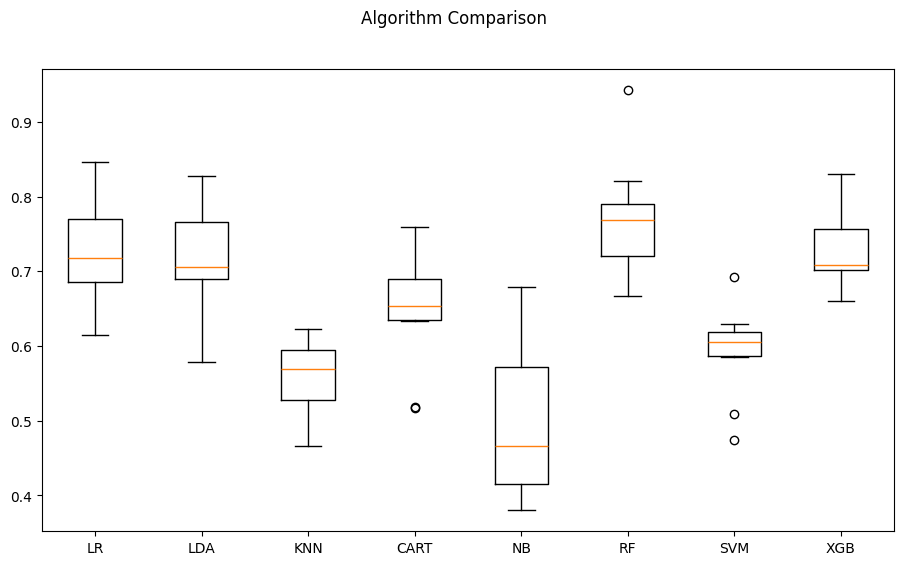

In [10]:
synth_data = transformar_dados(synth_data)
synth_data = synth_data.drop(synth_data[synth_data['Risk_bad'] == False].index)
df0 = pd.concat([df, synth_data])
treinar(df0, "synth")

In [12]:
models_df

,original,ctgan,synth
LR,0.399643,0.624209,0.730471
LDA,0.424515,0.599761,0.720072
KNN,0.282062,0.416921,0.558996
CART,0.464304,0.622742,0.644022
NB,0.610248,0.367157,0.495317
RF,0.392568,0.623073,0.770556
SVM,0.143989,0.463745,0.593010
XGB,0.473971,0.651900,0.730293
